In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import PIL

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import configparser as ConfigParser

import utils
# Ipmport various network architectures
from networks import AGRadGalNet
# Import various data classes
from datasets import FRDEEPF
from datasets import MiraBest_full, MBFRConfident, MBFRUncertain, MBHybrid
from datasets import MingoLoTSS, MLFR, MLFRTest

# Set seeds for reproduceability
torch.manual_seed(42)
np.random.seed(42)

# Get correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Read in config file
config_name = "configs/bowles2021mirabest.cfg"
config = ConfigParser.ConfigParser(allow_no_value=True)
config.read(config_name)

# Load network architecture (with random weights)
print(f"Loading in {config['model']['base']}")
net = locals()[config['model']['base']](**config['model']).to(device)

Loading in AGRadGalNet


In [2]:
# Create data transformations
datamean = config.getfloat('data', 'datamean')
datastd = config.getfloat('data', 'datastd')
number_rotations = config.getint('data', 'number_rotations')
imsize = config.getint('data', 'imsize')
scaling_factor = config.getfloat('data', 'scaling')
angles = list(range(0, 360, config.getint('data', 'number_rotations')))
p_flip = 0.5 if config.getboolean('data','flip') else 0

# Create hard random (seeded) rotation:
class RotationTransform:
    """Rotate by one of the given angles."""
    def __init__(self, angles, resample):
        self.angles = angles
        self.resample = resample

    def __call__(self, x):
        angle = np.random.choice(a=self.angles, size=1)
        return transforms.functional.rotate(x, angle, resample=self.resample)


# Compose dict of transformations
transformations = {
    'none': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([datamean],[datastd])
    ]),
    'rotation and flipping': transforms.Compose([
        transforms.CenterCrop(imsize),
        transforms.RandomVerticalFlip(p=p_flip),
        RotationTransform(angles, resample=PIL.Image.BILINEAR),
        transforms.RandomAffine(
            degrees=0, # No uncontrolled rotation
            scale=(1-scaling_factor, 1+scaling_factor), 
            resample=PIL.Image.BILINEAR),
        transforms.ToTensor(),
        transforms.Normalize([datamean],[datastd])
    ]),
    'no rotation no flipping': transforms.Compose([
        transforms.CenterCrop(imsize),
        transforms.RandomVerticalFlip(p=p_flip),
        transforms.RandomAffine(
            degrees=0, # No uncontrolled rotation
            scale=(1-scaling_factor, 1+scaling_factor), 
            resample=PIL.Image.BILINEAR),
        transforms.ToTensor(),
        transforms.Normalize([datamean],[datastd])
    ])
}

# Read / Create Folder for Data to be Saved
root = config['data']['directory']
os.makedirs(root, exist_ok=True)
download = True
train = True
data_class = locals()[config['data']['dataset']]
data_set = data_class(root=root, download=download, train=train, transform=transformations['rotation and flipping'])

# Seperate Data into Subsets for Training, Validation, Testing.
train_data = data_class(root=root, download=download, train=True, transform=transformations['rotation and flipping'])
test_data = data_class(root=root, download=download, train=False, transform=transformations['rotation and flipping'])

#train_batched = torch.utils.data.DataLoader(traindata, batch_size=config.getint('training', 'batch_size'))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Get data parameters
batch_size = config.getint('training', 'batch_size')
validation_size = config.getfloat('training', 'validation_set_size')
dataset_size = len(train_data)
nval = int(validation_size*dataset_size)
indices = list(range(dataset_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[nval:], indices[:nval]

train_sampler = torch.utils.data.Subset(train_data, train_indices)
valid_sampler = torch.utils.data.Subset(train_data, val_indices)

train_loader = torch.utils.data.DataLoader(train_sampler, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_sampler, batch_size=batch_size, shuffle=True)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [4]:
learning_rate = config.getfloat('training', 'learning_rate')
optimizers = {
    'SGD': optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9),
    'Adagrad': optim.Adagrad(net.parameters(), lr=learning_rate),
    'Adadelta': optim.Adadelta(net.parameters(), lr=learning_rate),
    'Adam': optim.Adam(net.parameters(), lr=learning_rate)
}

In [5]:
augmentation_loops = config.getint('data', 'number_rotations')
if config.getboolean('data', 'flip'):
    augmentation_loops = augmentation_loops*2
save_validation_updates = True
class_splitting_index = 1
loss_function = nn.CrossEntropyLoss()
optim_name = config['training']['optimizer']
optimizer = optimizers[optim_name]
training_results = {
    'train_loss': 0,
    'validation_loss': 0,
    'validation_confussion_matrix': 0,
    'validation_update': False
}
df = pd.DataFrame(columns = list(training_results.keys()))
folder_name = config['output']['directory']
output_evaluation_path = config['output']['training_evaluation']
output_models_path = config['output']['model_file']
os.makedirs(folder_name, exist_ok=True)

# Variable selections
validation_loss_min = np.Inf
Epoch = config.getint('training', 'epochs')
for epoch_count in range(Epoch):

    # Model Training
    train_loss = 0.
    validation_loss = 0.
    confussion_matrix = np.zeros((2,2))
    net.train() #Set network to train mode.
    if 'binary_labels' in locals():
        del binary_labels
    if 'outputs' in locals():
        del outputs

    # Loop across random data augmentations
    for i in range(augmentation_loops):
        for batch_idx , (data, labels) in enumerate(train_loader): #Iterates through each batch.
            data = data.to(device)
            labels = labels.to(device)

            # Create binary labels to remove morphological subclassifications (for MiraBest)
            binary_labels = np.zeros(labels.size(), dtype=int)
            binary_labels = np.where(labels.cpu().numpy()<class_splitting_index, binary_labels, binary_labels+1)
            binary_labels = torch.from_numpy(binary_labels).to(device)

            pred = net.forward(data)
            optimizer.zero_grad()
            loss = loss_function(pred,binary_labels)
            loss.backward(retain_graph=True)
            optimizer.step()
            train_loss += (loss.item()*data.size(0))


    ### Model Validation ###
    net.eval()
    for epoch_valid in range(augmentation_loops):
        for batch_idx, (data, labels) in enumerate(valid_loader):
            data = data.to(device)
            labels = labels.to(device)

            # Create binary labels to remove morphological subclassifications
            binary_labels = np.zeros(labels.size(), dtype=int)
            binary_labels = np.where(labels.cpu().numpy()<class_splitting_index, binary_labels, binary_labels+1)
            binary_labels = torch.from_numpy(binary_labels).to(device)

            outputs = net.forward(data)
            loss = loss_function(outputs, binary_labels)
            validation_loss += (loss.item()*data.size(0))
            
            predictions = np.argmax(outputs.detach().cpu().numpy(), axis=1)
            target_values = binary_labels.detach().cpu().numpy()
            for x, y in zip(predictions, target_values):
                confussion_matrix[x,y] += 1

    # Average losses (scaled according to validation dataset size)
    validation_loss = validation_loss/(len(valid_loader.dataset)*augmentation_loops)
    train_loss = train_loss/(len(train_loader.dataset)*augmentation_loops)
    training_results['train_loss'] = train_loss
    training_results['validation_loss'] = validation_loss
    training_results['validation_confussion_matrix'] = confussion_matrix

    # Print
    print(f"Epoch:{epoch_count:3}\tTraining Loss: {training_results['train_loss']:8.6f}\t\tValidation Loss: {training_results['validation_loss']:8.6f}")

    # Save model if validation loss decreased
    if validation_loss <= validation_loss_min:
        print(f"\tValidation Loss Down: \t({validation_loss_min:8.6f}-->{validation_loss:8.6f}) ... Updating saved model.")
        training_results['validation_update'] = True
        if save_validation_updates:
            torch.save(net.state_dict(), f"{folder_name}/{epoch_count}.pt")
        else:
            torch.save(net.state_dict(), f"{folder_name}/{output_models_path}")
        validation_loss_min = validation_loss
    else:
        training_results['validation_update'] = False

    
    # Save training loss / validation loss for plotting
    df = df.append(training_results, ignore_index=True)


df.to_csv(f'{folder_name}/{output_evaluation_path}', index=False)
print(f"\nFinished training.\nMinimum Validation Loss: {validation_loss_min:8.6}\n")

# Save final model, no matter the loss
torch.save(net.state_dict(), f'{folder_name}/last.pt')

/usr/local/anaconda-python-3.6/lib/python3.6/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch:  0	Training Loss: 0.626465		Validation Loss: 0.568891
	Validation Loss Down: 	(     inf-->0.568891) ... Updating saved model.
Epoch:  1	Training Loss: 0.588104		Validation Loss: 0.568970
Epoch:  2	Training Loss: 0.587432		Validation Loss: 0.568968
Epoch:  3	Training Loss: 0.587363		Validation Loss: 0.568969
Epoch:  4	Training Loss: 0.587279		Validation Loss: 0.568969

Finished training.
Minimum Validation Loss: 0.568891



tensor([[1.7334e-19, 1.0000e+00],
        [5.1791e-28, 1.0000e+00],
        [3.0462e-19, 1.0000e+00],
        [3.5267e-28, 1.0000e+00],
        [7.2231e-16, 1.0000e+00],
        [3.8350e-19, 1.0000e+00],
        [0.0000e+00, 1.0000e+00],
        [6.2049e-16, 1.0000e+00],
        [1.4988e-21, 1.0000e+00],
        [9.4199e-24, 1.0000e+00],
        [4.7575e-21, 1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>)
[1 1 1 1 1 1 1 1 1 1 1]
[0 1 1 1 0 0 0 1 1 1 1]


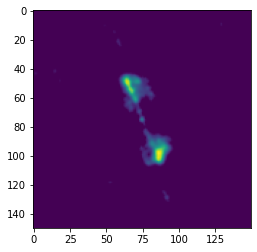

In [6]:
outputs = net.forward(data)
print(outputs)
print(np.argmax(outputs.detach().cpu().numpy(), axis=1))
print(binary_labels.cpu().numpy())
img = data[3].cpu().numpy().squeeze()
plt.imshow(img)
plt.show()

[[   0.    0.]
 [1792. 5216.]]


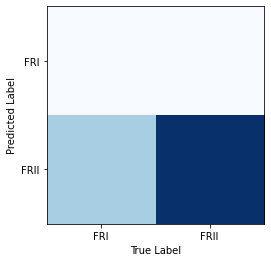

7008.0
7033.6


In [12]:
print(confussion_matrix)
plt.imshow(confussion_matrix, cmap='Blues')
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.xticks([0,1],['FRI','FRII'])
plt.yticks([0,1],['FRI','FRII'])
plt.show()
print(confussion_matrix.sum())
print(len(train_data)*0.2*16*2)

Data Manipulation:
- path_to_model(file_name)
- data_call(dataset_name)
- determine_dataset(dataset,model_name) ... dataset in ['automatic','FRDEEP-F','MiraBest']

Model Manipulation:
- load_net(model_name,device)
- training_validation(PATH,xlims=[None,None],save=False,full_path=False) ... PATH is a local title of a folder or file (within ./TrainedNetworks)
- prediction(dataset, net, class_groups,(device='cuda',reps='360'))
- evaluate(file_name, dataset='automatic')

Evaluation Plots:
- plot_conf_mat(conf_matrix,normalised=True,n_classes=2,format_input=None,title='Confusion Matrix')
- plot_roc_curve(fpr,tpr,title='ROC Curve (AUC=\{auc:.3f\})')
- out_print(out)

Attention Maps:
- attentions_func(batch_of_images, net, mean=True, device=torch.device('cpu'))
- attention_analysis(source, source_only=True, attention_maps=None, GradCAM=None)
- AttentionImagesByEpoch(sources, folder_name, net,epoch=1500, device=torch.device('cpu'))
- attention_epoch_plot(source_images,folder_name, logged=False, width=3, device=torch.device('cpu'))

GradCAM:
- To be completed.

Other:
- mask_on_image(img, mask)
- SortedDataSamples(data_name, transformed=True,  rotations=1, subset='NOHYBRID')
- net_name_extraction(PATH)

Incomplete:
- Loading from Pickled dicts
- GradCAM Call for a given image